# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

#1.1- Introducción:
En esta primera entrega, exploraremos un subconjunto de datos derivados de señales ECG (intervalos RR). El objetivo es familiarizarnos con las variables estadísticas (mean_rr, std_rr, skew_rr, kurt_rr) y analizar cómo se relacionan con el diagnóstico de ritmos normales vs. fibrilación auricular (AFib). En primera intancia con datos de prueba y posteriormente con datos reales

In [42]:
#======================================
# 1.2- Cargar el dataset
#======================================

def plot_ecg_segment(data_dir, duration=10, fs=300):
    import os
    import scipy.io as sio
    import numpy as np
    import matplotlib.pyplot as plt

    mat_files = sorted(f for f in os.listdir(data_dir) if f.endswith('.mat'))
    if not mat_files:
        print(f"⚠️ No se encontraron archivos .mat en {data_dir}")
        return
    file0 = mat_files[0]
    mat = sio.loadmat(os.path.join(data_dir, file0))
    signal = mat.get('val', mat.get('ECG', None))
    if signal is None:
        raise KeyError("La señal no está bajo 'val' ni 'ECG'")
    sig = signal.flatten()

    n = min(len(sig), fs * duration)
    t = np.arange(n) / fs
    plt.figure(figsize=(12,3))
    plt.plot(t, sig[:n], lw=0.8)
    plt.title(f"{file0} — primeros {duration}s")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.xlim(0, duration)
    plt.show()

# Clonar el repositorio
import os
if not os.path.exists('Proyecto-MachineLearning'):
    # !git clone https://github.com/BorisMejiasII/Proyecto-MachineLearning.git  # clonación silenciosa
    pass

%cd Proyecto-MachineLearning

# Cargar el CSV
import pandas as pd
rr_df = pd.read_csv('ecg_rr_features_curado.csv')

#======================================
# 1.3- Vista previa
#======================================
print(f"Datos cargados por el ecg_rr_features_curado.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

from IPython.display import display
display(rr_df.style
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', ''),
                      ('font-weight', 'bold'),
                      ('text-align', 'center')]
        }, {
            'selector': 'td',
            'props': [('padding', '4px'),
                      ('text-align', 'center')]
        }])
        .set_properties(**{'border': '1px solid #ddd'}))


/content/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning
Datos cargados por el ecg_rr_features_curado.csv


,mean_rr,std_rr,skew_rr,kurt_rr,label
0,849.671415,37.965868,0.404165,3.097078,Normal
1,786.173570,87.045564,0.462868,3.968645,AFib
2,864.768854,49.730056,0.278733,2.297947,Normal
3,952.302986,28.845781,0.260759,2.672338,AFib
4,776.584663,66.450898,0.662505,2.607892,AFib
5,776.586304,25.583127,0.771248,1.536485,Normal
6,957.921282,54.177272,0.485598,3.296120,Normal
7,876.743473,10.806598,0.700707,3.261055,AFib
8,753.052561,23.436279,0.572327,3.005113,Normal
9,854.256004,53.937225,0.370976,2.765413,Normal


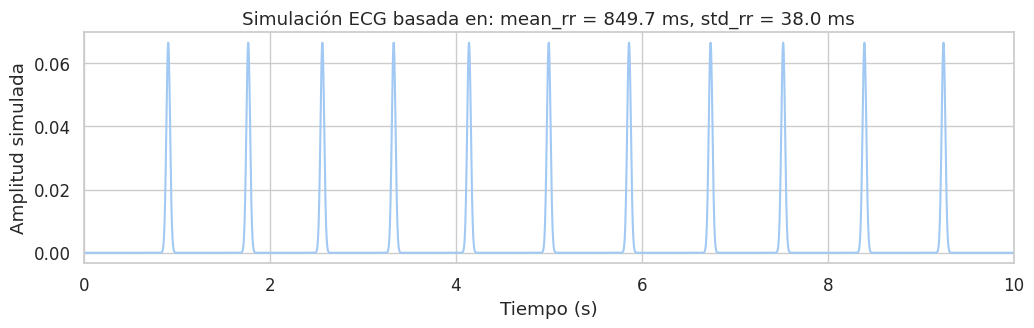

In [43]:
#======================================
# 1.4 - Simular señal ECG desde estadísticas del CSV
#======================================
import numpy as np
import matplotlib.pyplot as plt

def simulate_ecg_from_rr(mean_rr_ms, std_rr_ms, duration_s=10, fs=300):
    """
    Simula una señal ECG simple basada en el RR medio y su desviación.
    """
    rr_mean_s = mean_rr_ms / 1000
    rr_std_s = std_rr_ms / 1000

    # Tiempo total
    total_samples = fs * duration_s
    t = np.linspace(0, duration_s, total_samples)

    # Generamos picos tipo latidos: ubicaciones aproximadas
    rr_intervals = np.random.normal(loc=rr_mean_s, scale=rr_std_s, size=int(duration_s / rr_mean_s))
    rr_intervals = np.cumsum(rr_intervals)
    rr_intervals = rr_intervals[rr_intervals < duration_s]

    # Simulamos la señal: impulsos tipo R (forma de dientes)
    ecg = np.zeros_like(t)
    for peak_time in rr_intervals:
        idx = int(peak_time * fs)
        if 0 <= idx < len(ecg):
            ecg[idx] = 1  # latido

    # Suavizamos (simulación muy simple)
    from scipy.ndimage import gaussian_filter1d
    ecg_smooth = gaussian_filter1d(ecg, sigma=fs//50)

    # Gráfico
    plt.figure(figsize=(12, 3))
    plt.plot(t, ecg_smooth)
    plt.title(f"Simulación ECG basada en: mean_rr = {mean_rr_ms:.1f} ms, std_rr = {std_rr_ms:.1f} ms")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud simulada")
    plt.xlim(0, duration_s)
    plt.grid(True)
    plt.show()

#======================================
# Ejemplo: usar la primera fila del CSV
#======================================
row = rr_df.iloc[0]
simulate_ecg_from_rr(row['mean_rr'], row['std_rr'])


## 2. Resumen del artículo base (Clifford et al., 2017)

El PhysioNet/Computing in Cardiology Challenge 2017 presenta un dataset de señales ECG de corta duración para la detección automática de fibrilación auricular mediante técnicas de machine learning. El artículo demuestra que las características estadísticas derivadas de los intervalos RR (tiempo entre latidos consecutivos) proporcionan información suficiente para distinguir entre ritmos normales y patológicos, ofreciendo una alternativa computacionalmente eficiente al análisis de la señal ECG completa. Esta aproximación es especialmente valiosa para aplicaciones clínicas en dispositivos portátiles, donde la simplicidad y robustez son factores críticos para la implementación práctica del diagnóstico automatizado.



## 3. Análisis del dataset (cantidad de señales, duración, etiquetas, etc.)

In [44]:
#=====================================
# 3.1 Análisis del dataset
#=====================================

from IPython.display import Markdown, display

# 🔢 Total de registros
display(Markdown(f"**🔢 Total de registros:** {len(rr_df)}"))

# 📊 Distribución de clases
dist = rr_df['label'].value_counts().rename_axis('label').reset_index(name='count')
dist = dist.set_index('label')
display(dist.style
        .bar(subset=['count'], color='#5DADE2')
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', ''),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [
                ('padding', '4px'),
                ('text-align', 'center')
            ]}
        ])
        .set_properties(**{'border': '1px solid #ddd'}))

print("============================")

# 📈 Estadísticas por clase
stats = rr_df.groupby('label').describe().T
display(stats.style
        .background_gradient(cmap='Blues')
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', ''),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [
                ('padding', '4px'),
                ('text-align', 'center')
            ]}
        ])
        .set_properties(**{'border': '1px solid #ddd'}))


**🔢 Total de registros:** 30

,count
label,
Normal,18
AFib,12


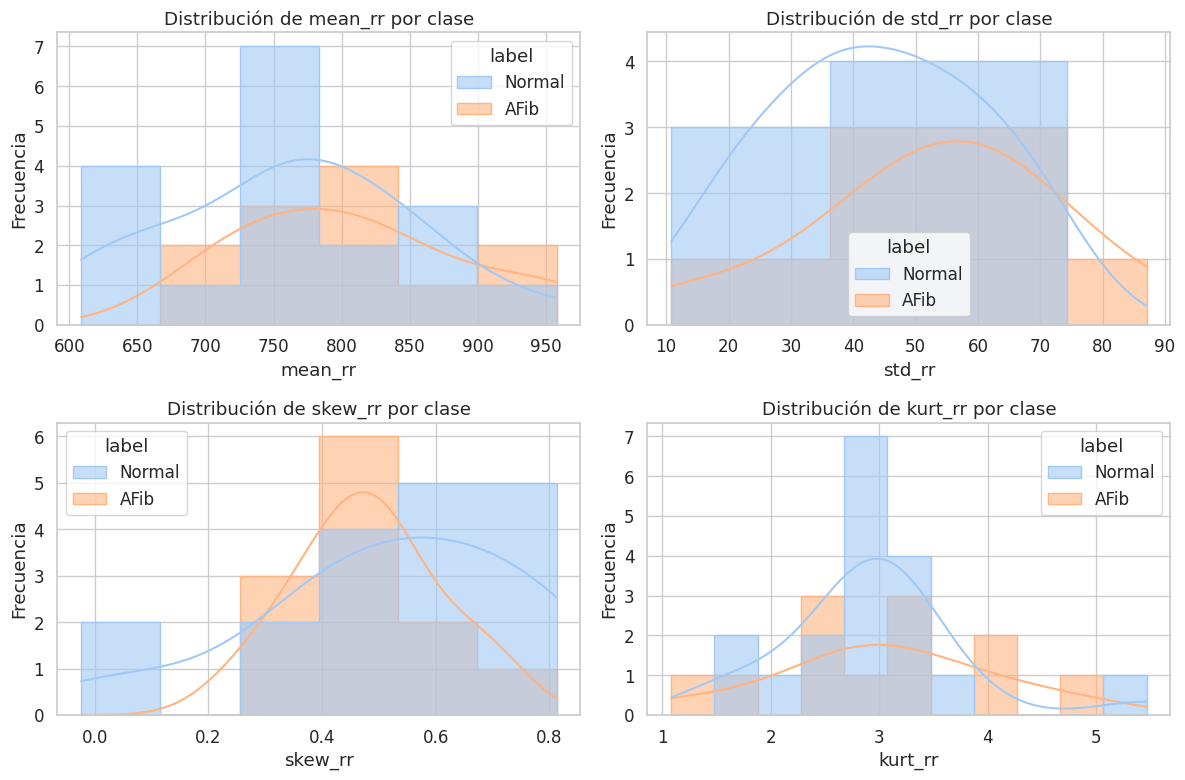

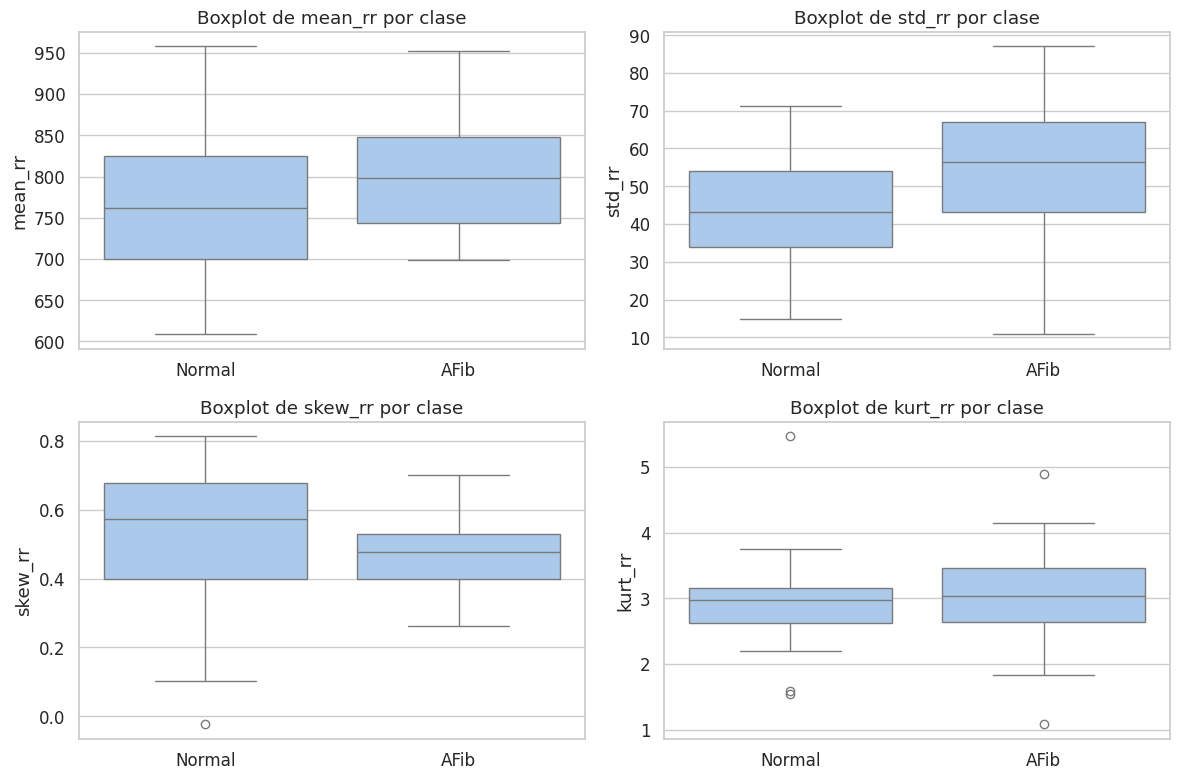

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']

# 4.1 – Histograma + KDE (2x2) sin errores de legend
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features):
    sns.histplot(
        data=rr_df,
        x=feat,
        hue='label',
        kde=True,
        element='step',
        ax=ax,
        alpha=0.6
    )
    ax.set_title(f'Distribución de {feat} por clase')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frecuencia')
fig.tight_layout()
plt.show()
print("================================================================================================================================")


# 4.2 – Boxplots organizados en grid (2x2) sin FutureWarning
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(
        data=rr_df,
        x='label',
        y=feat,
        ax=ax
    )
    ax.set_title(f'Boxplot de {feat} por clase')
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout()
plt.show()


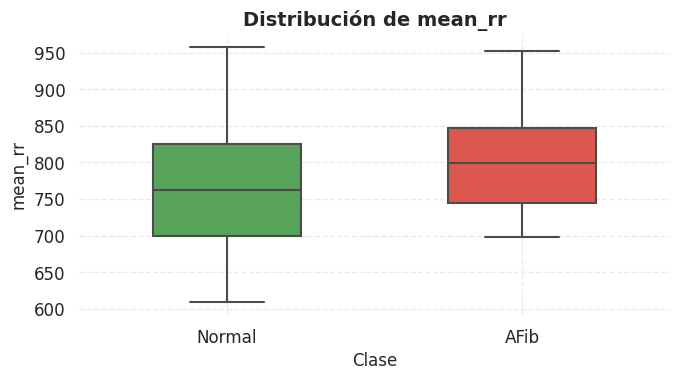

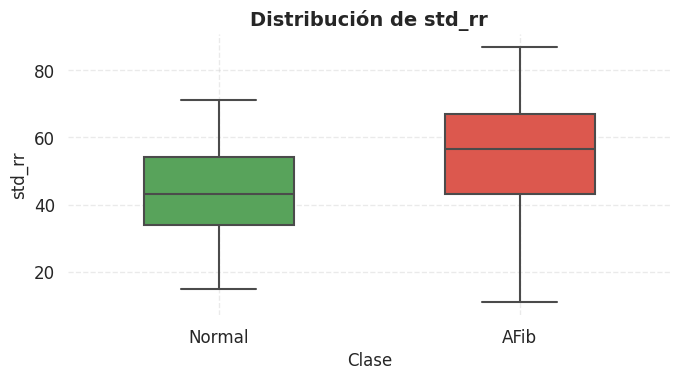

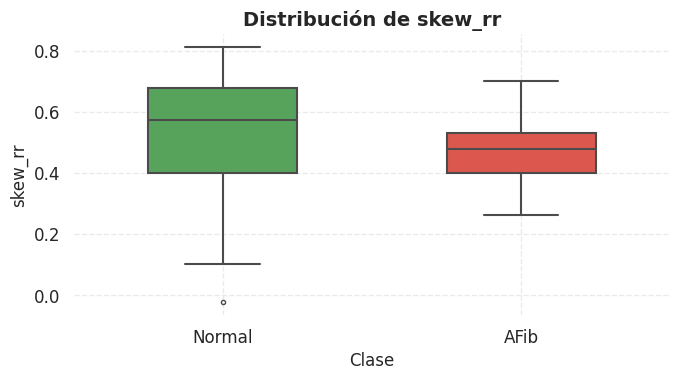

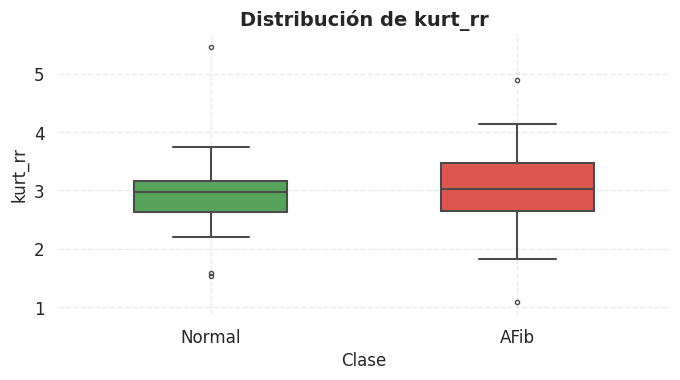

In [46]:
#===============================================
# 4.3 - Boxplots por cada clase
#===============================================
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
palette = {'Normal': '#4CAF50', 'AFib': '#F44336'}

for feature in features:
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(
        data=rr_df,
        x='label',
        y=feature,
        hue='label',
        palette=palette,
        width=0.5,
        linewidth=1.5,
        fliersize=3,
        dodge=False
    )
    print("=======================================================================================")
    ax.set_title(f'Distribución de {feature}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Clase', fontsize=12)
    ax.set_ylabel(feature, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    sns.despine(left=True, bottom=True)

    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.tight_layout()
    plt.show()


# 5. Conclusión

Como conclusión de esta primera parte se puede decir que el análisis exploratorio revela que las características estadísticas de los intervalos RR poseen un potencial bastante discriminativo para la clasificación de arritmias cardíacas. Por otro lado, las variables std_rr y kurt_rr muestran las diferencias más marcadas entre ritmos normales y fibrilación auricular, reflejando la naturaleza irregular característica de esta arritmia, mientras que mean_rr aporta información complementaria sobre la frecuencia cardíaca promedio. Aunque el dataset actual es limitado (30 muestras), los patrones observados son consistentes con la fisiopatología conocida de la AFib y sugieren que un modelo de machine learning basado en estas características podría alcanzar un rendimiento diagnóstico aceptable. El próximo paso será implementar y evaluar algoritmos de clasificación como regresión logística o Random Forest para validar cuantitativamente el poder predictivo de estas variables.

# Ahora veamos lo mismo pero no con datos de prueba, sino que con datos Reales sacados de Training2017



In [47]:
# 0. Clonar el repositorio con tus datos reales (solo si no está)
import os
if not os.path.isdir('Proyecto-MachineLearning'):
    !git clone https://github.com/BorisMejiasII/Proyecto-MachineLearning.git

%cd Proyecto-
print("Contenido de la raíz del proyecto:", os.listdir())
print("Dentro de 'Datos De Prueba':", os.listdir('Datos De Prueba'))


Cloning into 'Proyecto-MachineLearning'...
remote: Enumerating objects: 1052, done.
remote: Counting objects: 100% (1052/1052), done.
remote: Compressing objects: 100% (1043/1043), done.
remote: Total 1052 (delta 22), reused 1025 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (1052/1052), 6.77 MiB | 24.39 MiB/s, done.
Resolving deltas: 100% (22/22), done.
[Errno 2] No such file or directory: 'Proyecto-'
/content/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning
Contenido de la raíz del proyecto: ['ecg_rr_features_curado.csv', 'Proyecto-MachineLearning', 'Semana_1_Exploracion.ipynb', 'README-Leer antes de ejecutar el código.txt', 'Datos De Prueba', '.git']
Dentro de 'Datos De Prueba': ['A00314.mat', 'A00345.mat', 'A00016.mat', 'A00351.hea', 'A00148.mat', 'A00231.hea', 'A00336.hea', 'A00463.hea', 'A00203.hea', 'A00089.mat', 'A00060.hea', 'A00186.mat', 'A00306.hea', 'A00376.mat', 'A00450.hea', 'A00210.mat', 'A00214.hea', 'A00005.mat', 'A00158.mat', 'A00

In [74]:
import importlib.util
if importlib.util.find_spec("wfdb") is None:
    !pip install wfdb

#Cargar datos reales y extraer características
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from wfdb import rdrecord

DATA_DIR = 'Datos De Prueba'    # Carpeta con los datos .mat/.hea

# Cargar las etiquetas desde el archivo REFERENCE.csv (¡CAMBIO AQUÍ!)
reference_file = os.path.join(DATA_DIR, 'REFERENCE.csv')  # ← EXTENSIÓN .csv AÑADIDA
print(f"🔍 Cargando etiquetas desde: {reference_file}")

# Leer el archivo de referencia y crear un diccionario de etiquetas
labels_dict = {}
try:
    with open(reference_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line and ',' in line:
                record_id, label_code = line.split(',')
                # Mapear las etiquetas
                if label_code == 'N':
                    labels_dict[record_id] = 'Normal'
                elif label_code == 'A':
                    labels_dict[record_id] = 'AFib'
                elif label_code == 'O':
                    labels_dict[record_id] = 'Other'
                else:
                    labels_dict[record_id] = 'Unknown'

    print(f"✅ Etiquetas cargadas para {len(labels_dict)} registros")

    # Mostrar distribución de etiquetas
    label_counts = {}
    for label in labels_dict.values():
        label_counts[label] = label_counts.get(label, 0) + 1

    print("📊 Distribución de etiquetas en archivo REFERENCE:")
    for label, count in sorted(label_counts.items()):
        print(f"   - {label}: {count}")

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo {reference_file}")
    print("   Archivos disponibles en la carpeta:")
    for f in os.listdir(DATA_DIR):
        print(f"   - {f}")
    raise

# Listado de todos los registros disponibles (.mat sin extensión)
all_records = sorted(f[:-4] for f in os.listdir(DATA_DIR) if f.endswith('.mat'))
print(f"🔍 Archivos .mat encontrados: {len(all_records)}")

# Separar registros por etiqueta usando el diccionario de referencia
normal_records = []
afib_records = []
other_records = []
unknown_records = []

print("🔍 Clasificando registros por etiqueta...")
for rec_name in all_records:
    if rec_name in labels_dict:
        label = labels_dict[rec_name]
        if label == 'Normal':
            normal_records.append(rec_name)
        elif label == 'AFib':
            afib_records.append(rec_name)
        elif label == 'Other':
            other_records.append(rec_name)
        else:
            unknown_records.append(rec_name)
    else:
        print(f"⚠️  Registro {rec_name} no encontrado en archivo REFERENCE")
        unknown_records.append(rec_name)

print(f"📊 Registros clasificados:")
print(f"   - Normal: {len(normal_records)}")
print(f"   - AFib: {len(afib_records)}")
print(f"   - Other: {len(other_records)}")
print(f"   - Unknown: {len(unknown_records)}")
print(f"   - Total procesable: {len(normal_records) + len(afib_records) + len(other_records)}")

# Ajustable al número de datos de prueba que se deseen probar
N_SAMPLES = 50                                                                                     # <-- Esta es la variable que se puede modificar (de 2 a 100)
samples_per_class = N_SAMPLES // 2

# El código siempre va a dividir la entrada para que los datos de prueba intenten ser lo más equitativos posible,
# puesto que si los datos estuvieran desequilibrados no tendría sentido realizar una comparación más adelante
# Por eso siempre ingresar un múltiplo de 2 al querer probar, de lo contrario el código va a redondear al par más bajo cercano

selected_normal = normal_records[:min(samples_per_class, len(normal_records))]
selected_afib = afib_records[:min(samples_per_class, len(afib_records))]
if len(selected_normal) < samples_per_class and len(other_records) > 0:
    needed = samples_per_class - len(selected_normal)
    selected_other = other_records[:needed]
    selected_normal.extend(selected_other)

records = selected_normal + selected_afib
np.random.seed(42)
np.random.shuffle(records)


rows = []
for rec_name in records:
    try:
        rec = rdrecord(os.path.join(DATA_DIR, rec_name))
        sig = rec.p_signal[:,0]
        fs = int(rec.fs)
        dur_s = len(sig) / fs

        # Estadísticas de amplitud
        media = sig.mean()
        desv   = sig.std()
        skewn  = skew(sig)
        kurto  = kurtosis(sig)

        # Encontrar picos R y calcular RR
        peaks, _ = find_peaks(sig, distance=0.6*fs)
        rr = np.diff(peaks) / fs
        rr_mean = rr.mean() if rr.size else np.nan
        rr_std  = rr.std()  if rr.size else np.nan

        # Etiqueta desde el diccionario de referencia
        label = labels_dict.get(rec_name, 'Unknown')

        rows.append({
            'registro':  rec_name,
            'label':     label,
            'fs':        fs,
            'dur_s':     round(dur_s,2),
            'media_mv':  round(media,6),
            'std_mv':    round(desv,6),
            'skew_mv':   round(skewn,6),
            'kurt_mv':   round(kurto,6),
            'mean_rr_s': round(rr_mean,6),
            'std_rr_s':  round(rr_std,6)
        })
    except Exception as e:
        print(f"❌ Error procesando {rec_name}: {e}")

real_df = pd.DataFrame(rows)
print("✅ Datos reales cargados:", real_df.shape)

# Verificar distribución final
final_distribution = real_df['label'].value_counts()
print(f"📈 Distribución final en el DataFrame:")
for label, count in final_distribution.items():
    print(f"   - {label}: {count}")

display(real_df.head())

🔍 Cargando etiquetas desde: Datos De Prueba/REFERENCE.csv
✅ Etiquetas cargadas para 8528 registros
📊 Distribución de etiquetas en archivo REFERENCE:
   - AFib: 738
   - Normal: 5050
   - Other: 2456
   - Unknown: 284
🔍 Archivos .mat encontrados: 500
🔍 Clasificando registros por etiqueta...
📊 Registros clasificados:
   - Normal: 306
   - AFib: 46
   - Other: 134
   - Unknown: 14
   - Total procesable: 486
✅ Datos reales cargados: (50, 10)
📈 Distribución final en el DataFrame:
   - Normal: 25
   - AFib: 25


,registro,label,fs,dur_s,media_mv,std_mv,skew_mv,kurt_mv,mean_rr_s,std_rr_s
0,A00025,Normal,300,30.00,0.025850,0.234248,1.890243,7.507799,0.996437,0.054533
1,A00132,AFib,300,30.00,-0.006304,0.140132,0.185057,2.384148,0.901562,0.222668
2,A00054,AFib,300,30.00,0.037247,0.539993,2.641576,40.749947,0.834095,0.157571
3,A00216,AFib,300,30.00,0.022610,0.112674,3.207219,11.779337,0.810833,0.168362
4,A00032,Normal,300,28.98,0.011796,0.241188,-0.184336,7.359179,0.991149,0.061739


In [75]:
# Configuración de pandas y display
import pandas as pd
from IPython.display import display, Markdown

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(Markdown(f"**🔢 Registros cargados y procesados:** {len(real_df)}"))
display(real_df.style
        .set_table_styles([
            {'selector':'th','props':[
                ('background-color',''),
                ('font-weight','bold'),
                ('text-align','center')]},
            {'selector':'td','props':[
                ('text-align','center'),
                ('padding','4px')]},
        ])
        .set_properties(**{'border':'1px solid #ddd'}))


**🔢 Registros cargados y procesados:** 50

,registro,label,fs,dur_s,media_mv,std_mv,skew_mv,kurt_mv,mean_rr_s,std_rr_s
0,A00025,Normal,300,30.000000,0.025850,0.234248,1.890243,7.507799,0.996437,0.054533
1,A00132,AFib,300,30.000000,-0.006304,0.140132,0.185057,2.384148,0.901562,0.222668
2,A00054,AFib,300,30.000000,0.037247,0.539993,2.641576,40.749947,0.834095,0.157571
3,A00216,AFib,300,30.000000,0.022610,0.112674,3.207219,11.779337,0.810833,0.168362
4,A00032,Normal,300,28.980000,0.011796,0.241188,-0.184336,7.359179,0.991149,0.061739
5,A00231,AFib,300,60.000000,0.000755,0.116601,1.142000,3.695181,0.838873,0.220084
6,A00005,AFib,300,60.000000,0.020820,0.209003,2.241977,8.749932,0.832582,0.145675
7,A00004,AFib,300,30.000000,0.040544,0.213619,3.523494,14.134977,0.936042,0.178677
8,A00071,AFib,300,30.000000,0.030758,0.205001,3.541033,14.122188,0.878922,0.257576
9,A00035,Normal,300,30.000000,-0.001567,0.174598,-0.012204,3.982603,0.715447,0.017183


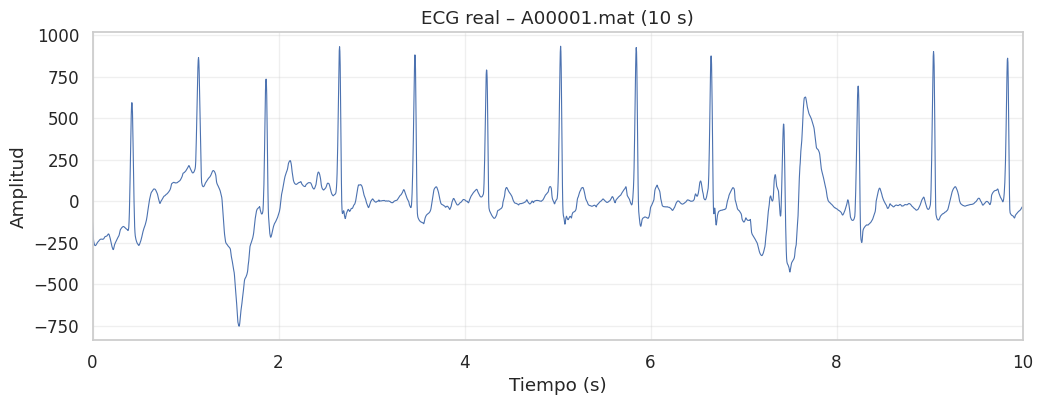

In [76]:
#======================================
# 1.4 - Función para cargar y plotear ECG reales
#======================================
def plot_ecg_segment(data_dir, file_index=0, duration=10, fs=300):
    """
    Carga y plotea un segmento de `duration` segundos de la señal
    del archivo .mat en la posición `file_index` dentro de data_dir.
    """
    import os
    import scipy.io as sio
    import numpy as np
    import matplotlib.pyplot as plt

    # 1) Listar y ordenar los .mat
    mat_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.mat')])
    if not mat_files:
        raise FileNotFoundError(f"No se encontraron archivos .mat en {data_dir}")
    if file_index < 0 or file_index >= len(mat_files):
        raise IndexError(f"file_index debe estar entre 0 y {len(mat_files)-1}")
    file0 = mat_files[file_index]

    # 2) Cargar la señal
    mat = sio.loadmat(os.path.join(data_dir, file0))
    signal = mat.get('val', mat.get('ECG', None))
    if signal is None:
        raise KeyError(f"La señal no está bajo 'val' ni 'ECG' en {file0}")
    sig = signal.flatten()

    # 3) Recortar a los primeros `duration` segundos
    n_samples = min(len(sig), fs * duration)
    time = np.arange(n_samples) / fs
    segment = sig[:n_samples]

    # 4) Plotear
    plt.figure(figsize=(12, 4))
    plt.plot(time, segment, lw=0.8)
    plt.title(f"ECG real – {file0} ({duration} s)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.xlim(0, duration)
    plt.grid(alpha=0.3)
    plt.show()

#======================================
# Uso de la función con tus datos reales
#======================================
DATA_DIR = 'Datos De Prueba'

# Plotea el primer archivo (.mat)
plot_ecg_segment(DATA_DIR, file_index=0)

# Si se desea ver otro, cambia el valor de file_index (considerando que el 0 es el A00001), por ejemplo
# plot_ecg_segment(DATA_DIR, file_index=5)


In [77]:
# 3.1 – Conteo y distribución por clase
from IPython.display import display, Markdown

display(Markdown(f"**🔢 Total de registros:** {len(real_df)}"))

dist = real_df['label'].value_counts().rename_axis('label').reset_index(name='count').set_index('label')
display(dist.style
        .bar(subset=['count'], color='#5DADE2')
        .set_table_styles([
            {'selector':'th','props':[
                ('background-color',''),
                ('font-weight','bold'),
                ('text-align','center')]},
            {'selector':'td','props':[
                ('text-align','center'),
                ('padding','4px')]}
        ])
        .set_properties(**{'border':'1px solid #ddd'}))

print("============================")

# 3.2 – Estadísticas descriptivas por clase
stats = real_df.groupby('label').describe().T
display(stats.style
        .background_gradient(cmap='Blues')
        .set_table_styles([
            {'selector':'th','props':[
                ('background-color',''),
                ('font-weight','bold'),
                ('text-align','center')]},
            {'selector':'td','props':[
                ('text-align','center'),
                ('padding','4px')]}
        ])
        .set_properties(**{'border':'1px solid #ddd'}))


**🔢 Total de registros:** 50

,count
label,
Normal,25
AFib,25


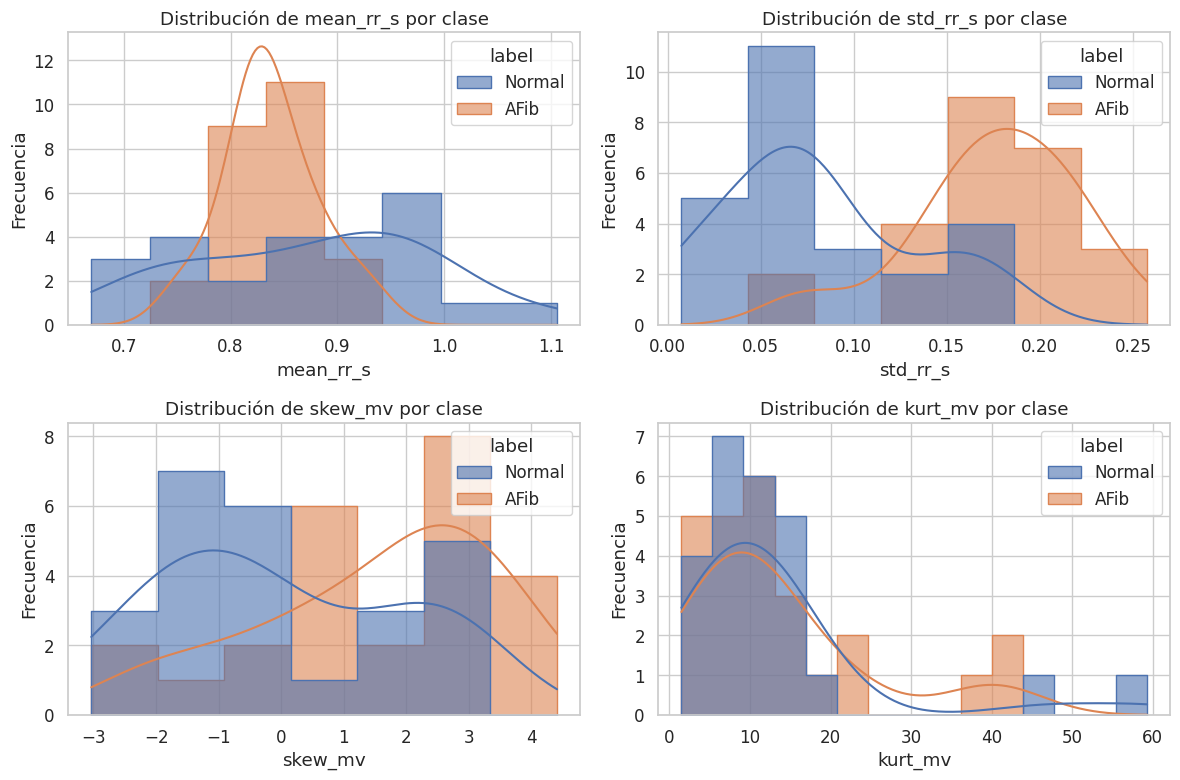

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

features_real = ['mean_rr_s','std_rr_s','skew_mv','kurt_mv']

# 4.1 Histogramas + KDE (grid 2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features_real):
    sns.histplot(
        data=real_df,
        x=feat,
        hue='label',
        kde=True,
        element='step',
        ax=ax,
        alpha=0.6
    )
    ax.set_title(f'Distribución de {feat} por clase')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frecuencia')
fig.tight_layout()
plt.show()


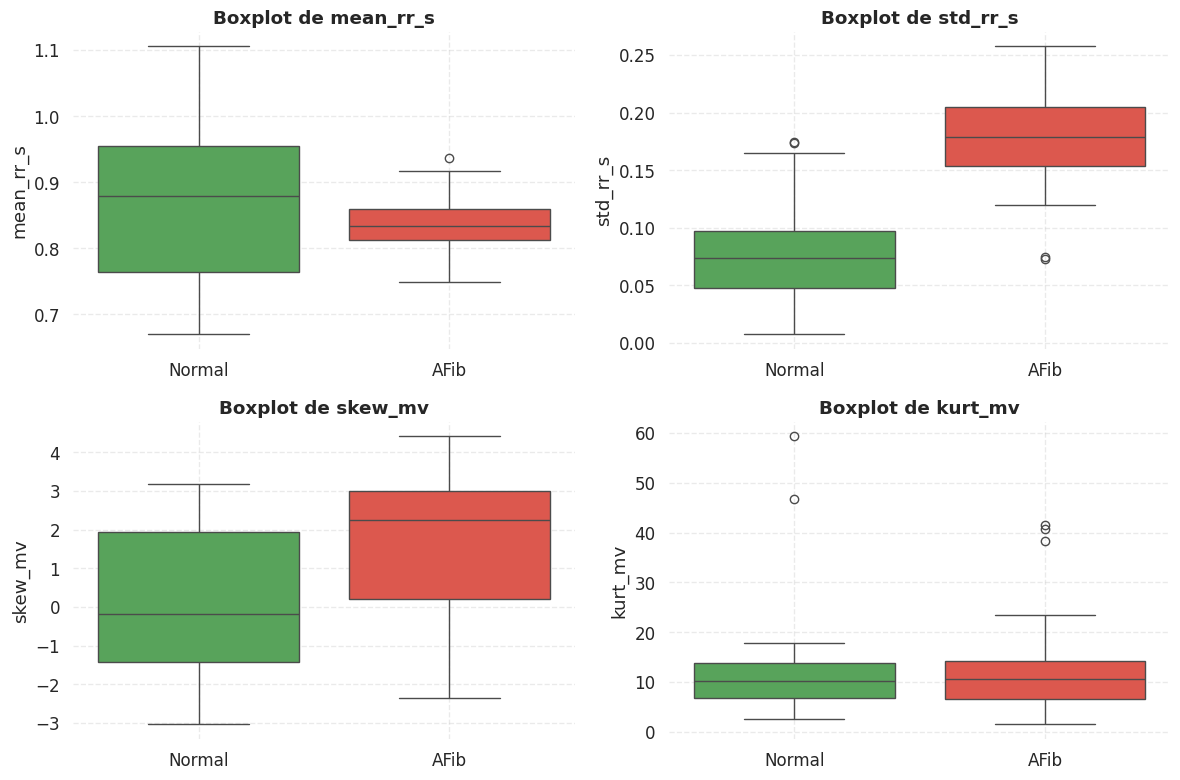

In [80]:
# 4.2 Boxplots embellecidos (grid 2x2)
sns.set(style="whitegrid", font_scale=1.1)
palette = {'Normal':'#4CAF50','AFib':'#F44336'}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features_real):
    sns.boxplot(
        data=real_df,
        x='label',
        y=feat,
        hue='label',
        palette=palette,
        dodge=False,
        ax=ax
    )
    if ax.get_legend():
        ax.get_legend().remove()
    ax.set_title(f'Boxplot de {feat}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(feat)
    ax.grid(True, linestyle='--', alpha=0.4)
    sns.despine(left=True, bottom=True)
fig.tight_layout()
plt.show()

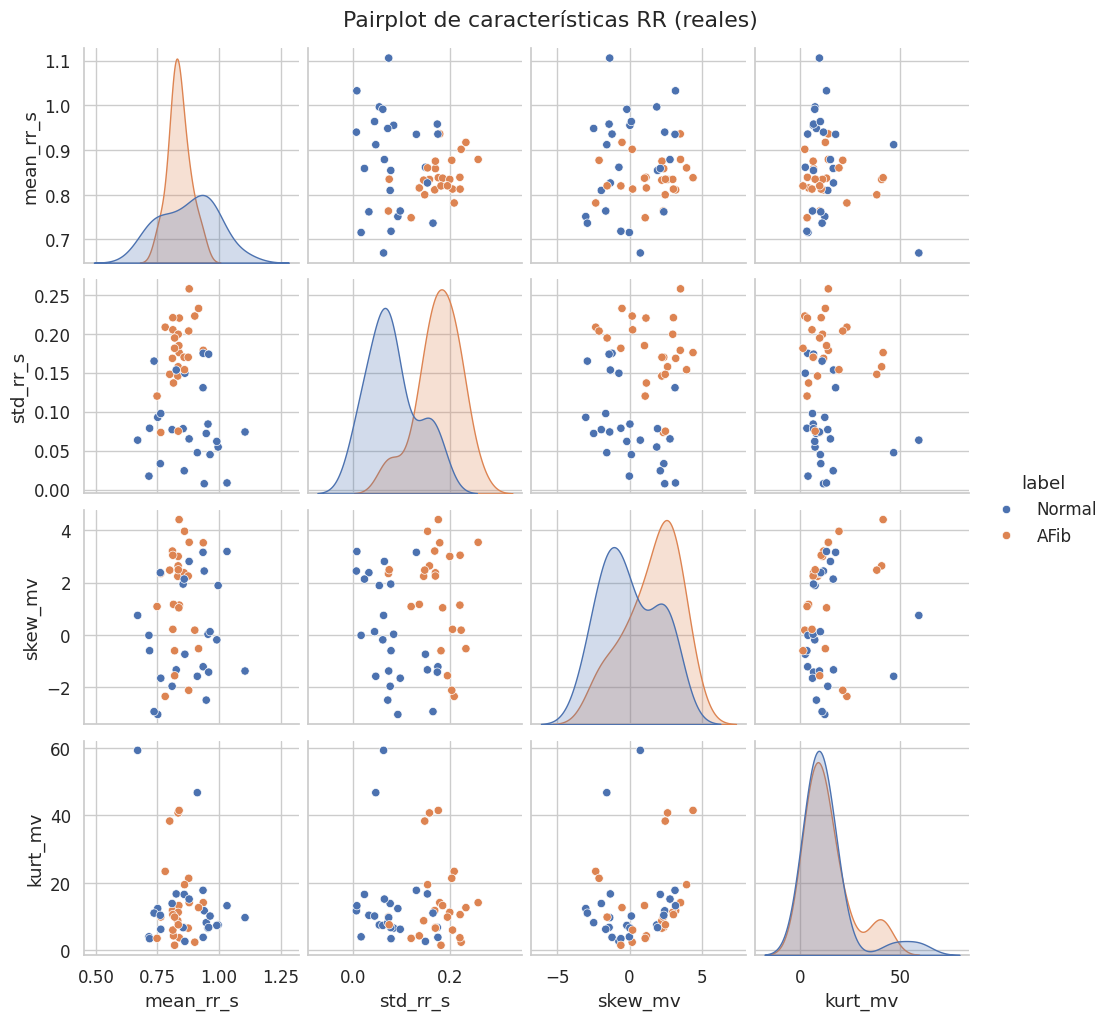

In [79]:
# 4.3 Pairplot
sns.pairplot(real_df, vars=features_real, hue='label', diag_kind='kde', height=2.5)
plt.suptitle("Pairplot de características RR (reales)", y=1.02)
plt.show()

#Explicación del Pairplot

Lo que muestra el pairplot es, en un solo gráfico, las distribuciones variadas de cada característica RR (KDE en la diagonal) junto con los diagramas de dispersión bivariantes (scatter plots) para cada par de variables (mean_rr_s, std_rr_s, skew_mv, kurt_mv), donde cada punto está coloreado según su clase (Normal vs. AFib). Esto permite apreciar, por ejemplo, que los casos de AFib tienden a concentrarse en valores más altos de irregularidad de los intervalos RR (std_rr_s) y de curtosis (kurt_mv), mientras que la asimetría (skew_mv) presenta un solapamiento notable entre ambas clases y, por tanto, menos capacidad discriminativa.

#Conclusión sobre la misma prueba con datos reales

Como conclusión del análisis sobre los datos reales, encontramos que las métricas derivadas de los intervalos RR mantienen el mismo comportamiento observado en el CSV curado: la desviación estándar de los intervalos (std_rr_s) y la curtosis de la señal (kurt_mv) muestran las mayores diferencias entre ritmos normales y fibrilación auricular, evidenciando la irregularidad característica de la AFib, mientras que la media del RR (mean_rr_s) aporta información complementaria sobre la frecuencia cardíaca promedio. Por otro lado, la asimetría de la señal (skew_mv) presenta un solapamiento significativo entre ambas clases y, por tanto, un poder discriminativo más limitado. A pesar de la muestra reducida, estos resultados respaldan la viabilidad de entrenar un modelo de clasificación (por ejemplo, regresión logística o Random Forest) usando estas cuatro características para predecir arritmias con un rendimiento inicial prometedor.

📊 ANÁLISIS EXPLORATORIO DE DATOS ECG

1️⃣ INFORMACIÓN BÁSICA DEL DATASET
--------------------------------------------------
📋 Dimensiones del dataset: (50, 10)
📊 Variables numéricas: 8
🏷️ Variables categóricas: 2

📈 Distribución de clases:
   - Normal: 25 (50.0%)
   - AFib: 25 (50.0%)

2️⃣ ESTADÍSTICAS DESCRIPTIVAS POR CLASE
--------------------------------------------------

📊 Variable: fs
        count   mean  std  min  max
label                              
AFib       25  300.0  0.0  300  300
Normal     25  300.0  0.0  300  300

📊 Variable: dur_s
        count     mean      std    min   max
label                                       
AFib       25  31.2368   9.2722  17.15  60.0
Normal     25  34.6380  11.6627  18.57  60.0

📊 Variable: media_mv
        count    mean     std     min     max
label                                        
AFib       25  0.0133  0.0191 -0.0287  0.0405
Normal     25  0.0000  0.0198 -0.0660  0.0258

📊 Variable: std_mv
        count    mean     std     min

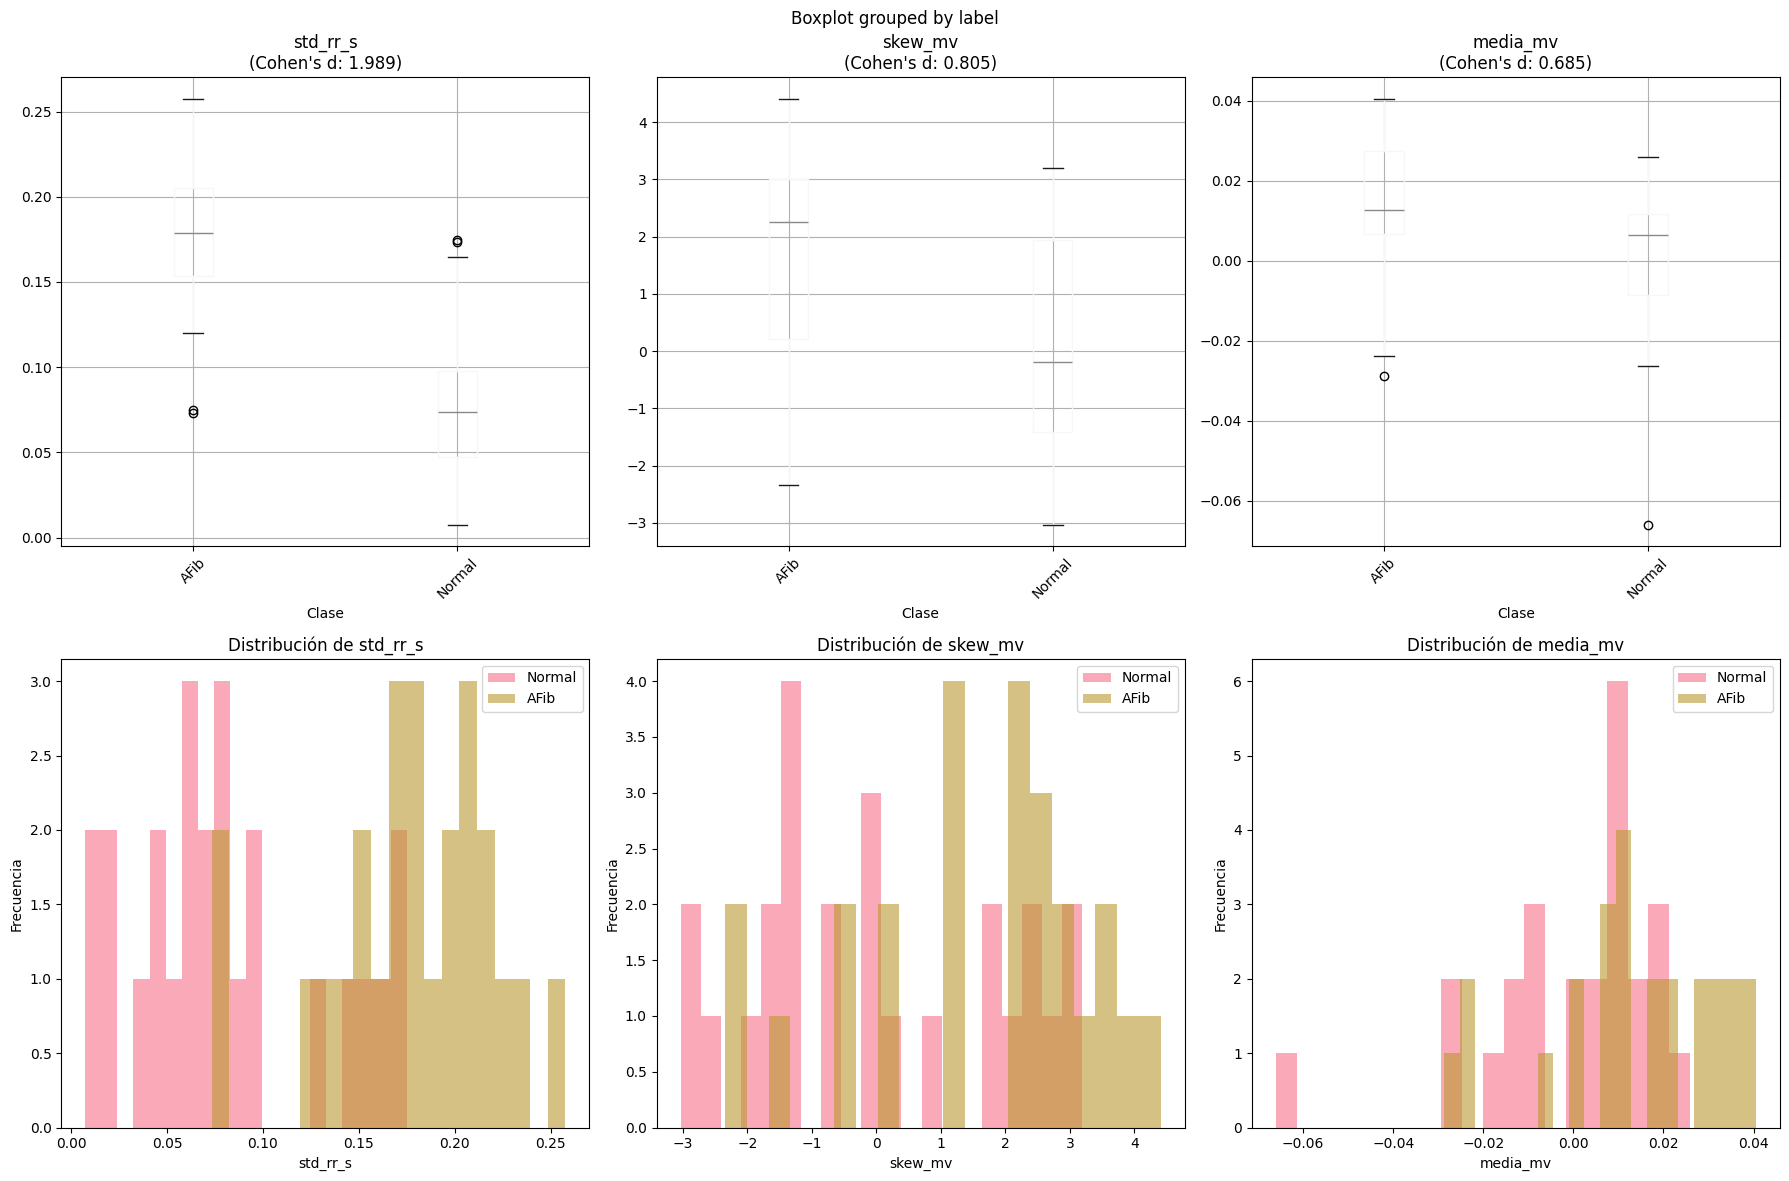


6️⃣ MATRIZ DE CORRELACIÓN
--------------------------------------------------
🔗 CORRELACIONES ALTAS DETECTADAS (|r| > 0.7):
   - media_mv ↔ skew_mv: r = 0.777


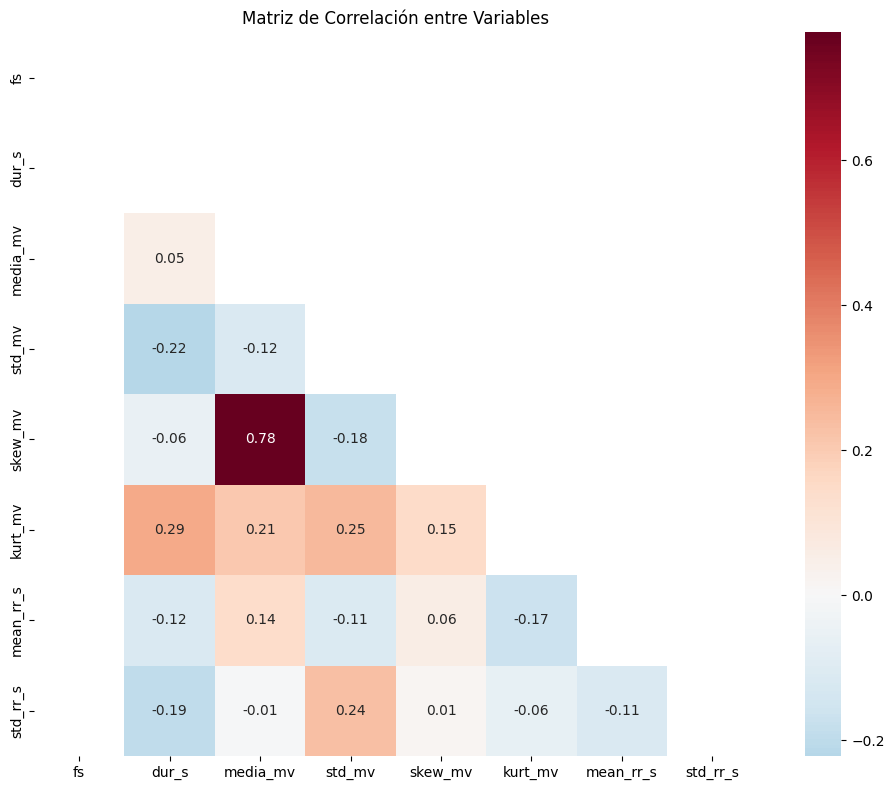

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")

print("=" * 80)
print("📊 ANÁLISIS EXPLORATORIO DE DATOS ECG")
print("=" * 80)

# 1. INFORMACIÓN BÁSICA DEL DATASET
print("\n1️⃣ INFORMACIÓN BÁSICA DEL DATASET")
print("-" * 50)
print(f"📋 Dimensiones del dataset: {real_df.shape}")
print(f"📊 Variables numéricas: {len(real_df.select_dtypes(include=[np.number]).columns)}")
print(f"🏷️ Variables categóricas: {len(real_df.select_dtypes(include=['object']).columns)}")

# Distribución de clases
print(f"\n📈 Distribución de clases:")
class_counts = real_df['label'].value_counts()
for label, count in class_counts.items():
    percentage = (count / len(real_df)) * 100
    print(f"   - {label}: {count} ({percentage:.1f}%)")

# 2. ESTADÍSTICAS DESCRIPTIVAS POR CLASE
print("\n2️⃣ ESTADÍSTICAS DESCRIPTIVAS POR CLASE")
print("-" * 50)

# Variables numéricas para análisis
numeric_vars = ['fs', 'dur_s', 'media_mv', 'std_mv', 'skew_mv', 'kurt_mv', 'mean_rr_s', 'std_rr_s']
available_vars = [var for var in numeric_vars if var in real_df.columns]

for var in available_vars:
    print(f"\n📊 Variable: {var}")
    stats_by_class = real_df.groupby('label')[var].agg(['count', 'mean', 'std', 'min', 'max'])
    print(stats_by_class.round(4))

# 3. ANÁLISIS DE DIFERENCIAS ENTRE CLASES
print("\n3️⃣ VARIABLES QUE MÁS DIFERENCIAN ENTRE CLASES")
print("-" * 50)

# Calcular estadísticas de separación entre clases
separation_stats = []

for var in available_vars:
    # Filtrar valores no nulos
    data_clean = real_df.dropna(subset=[var])

    if len(data_clean) > 0:
        # Separar por clases principales (Normal vs AFib)
        normal_data = data_clean[data_clean['label'] == 'Normal'][var]
        afib_data = data_clean[data_clean['label'] == 'AFib'][var]

        if len(normal_data) > 0 and len(afib_data) > 0:
            # Diferencia de medias
            mean_diff = abs(normal_data.mean() - afib_data.mean())

            # Diferencia de medias normalizada por desviación estándar combinada
            pooled_std = np.sqrt((normal_data.var() + afib_data.var()) / 2)
            cohen_d = mean_diff / pooled_std if pooled_std > 0 else 0

            # Test estadístico (t-test)
            try:
                t_stat, p_value = stats.ttest_ind(normal_data, afib_data)
            except:
                t_stat, p_value = 0, 1

            # Coeficiente de variación por clase
            cv_normal = normal_data.std() / abs(normal_data.mean()) if normal_data.mean() != 0 else 0
            cv_afib = afib_data.std() / abs(afib_data.mean()) if afib_data.mean() != 0 else 0

            separation_stats.append({
                'variable': var,
                'mean_normal': normal_data.mean(),
                'mean_afib': afib_data.mean(),
                'mean_diff': mean_diff,
                'cohen_d': cohen_d,
                'p_value': p_value,
                'cv_normal': cv_normal,
                'cv_afib': cv_afib
            })

# Ordenar por Cohen's d (tamaño del efecto)
separation_df = pd.DataFrame(separation_stats)
separation_df = separation_df.sort_values('cohen_d', ascending=False)

print("🎯 VARIABLES ORDENADAS POR CAPACIDAD DE DIFERENCIACIÓN (Cohen's d):")
print("   (Cohen's d: 0.2=pequeño, 0.5=mediano, 0.8=grande)")
for _, row in separation_df.iterrows():
    significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"   📊 {row['variable']:12} | Cohen's d: {row['cohen_d']:6.3f} | p-value: {row['p_value']:8.6f} {significance}")
    print(f"      Normal: μ={row['mean_normal']:8.4f} | AFib: μ={row['mean_afib']:8.4f}")

# 4. ASPECTOS LLAMATIVOS DEL DATASET
print("\n4️⃣ ASPECTOS LLAMATIVOS DEL DATASET")
print("-" * 50)

# Valores faltantes
print("🔍 VALORES FALTANTES:")
missing_info = real_df.isnull().sum()
for var, missing_count in missing_info.items():
    if missing_count > 0:
        percentage = (missing_count / len(real_df)) * 100
        print(f"   - {var}: {missing_count} ({percentage:.1f}%)")

if missing_info.sum() == 0:
    print("   ✅ No hay valores faltantes")

# Valores extremos (outliers)
print("\n🎯 DETECCIÓN DE VALORES EXTREMOS:")
for var in available_vars:
    data = real_df[var].dropna()
    if len(data) > 0:
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data < lower_bound) | (data > upper_bound)]
        if len(outliers) > 0:
            outlier_percentage = (len(outliers) / len(data)) * 100
            print(f"   - {var}: {len(outliers)} outliers ({outlier_percentage:.1f}%)")
            print(f"     Rango normal: [{lower_bound:.4f}, {upper_bound:.4f}]")
            print(f"     Outliers: min={outliers.min():.4f}, max={outliers.max():.4f}")

# Distribuciones de frecuencia de muestreo
print("\n📡 FRECUENCIAS DE MUESTREO:")
fs_counts = real_df['fs'].value_counts().sort_index()
for fs, count in fs_counts.items():
    percentage = (count / len(real_df)) * 100
    print(f"   - {fs} Hz: {count} registros ({percentage:.1f}%)")

# Duraciones de registros
print("\n⏱️ DURACIONES DE REGISTROS:")
duration_stats = real_df['dur_s'].describe()
print(f"   - Mínima: {duration_stats['min']:.2f} segundos")
print(f"   - Máxima: {duration_stats['max']:.2f} segundos")
print(f"   - Promedio: {duration_stats['mean']:.2f} segundos")
print(f"   - Mediana: {duration_stats['50%']:.2f} segundos")

# 5. VISUALIZACIONES
print("\n5️⃣ GENERANDO VISUALIZACIONES...")
print("-" * 50)

# Crear figura con subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio de Datos ECG', fontsize=16, fontweight='bold')

# Top 3 variables más discriminantes
top_vars = separation_df.head(3)['variable'].tolist()

for i, var in enumerate(top_vars):
    if i < 3:
        ax = axes[0, i]
        # Box plot por clase
        real_df.boxplot(column=var, by='label', ax=ax)
        ax.set_title(f'{var}\n(Cohen\'s d: {separation_df[separation_df["variable"]==var]["cohen_d"].iloc[0]:.3f})')
        ax.set_xlabel('Clase')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Histogramas de variables importantes
for i, var in enumerate(top_vars):
    if i < 3:
        ax = axes[1, i]
        for label in real_df['label'].unique():
            data = real_df[real_df['label'] == label][var].dropna()
            if len(data) > 0:
                ax.hist(data, alpha=0.6, label=label, bins=20)
        ax.set_title(f'Distribución de {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Frecuencia')
        ax.legend()

plt.tight_layout()
plt.show()

# 6. MATRIZ DE CORRELACIÓN
print("\n6️⃣ MATRIZ DE CORRELACIÓN")
print("-" * 50)

# Calcular correlaciones solo para variables numéricas
numeric_data = real_df[available_vars].select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Encontrar correlaciones altas
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:  # Correlación alta
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

if high_corr_pairs:
    print("🔗 CORRELACIONES ALTAS DETECTADAS (|r| > 0.7):")
    for var1, var2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"   - {var1} ↔ {var2}: r = {corr:.3f}")
else:
    print("✅ No se detectaron correlaciones altas entre variables")

# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, mask=mask, fmt='.2f')
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.show()

# Preguntas:

1. ¿Qué variables parecen diferenciar más entre clases?

Las variables que mejor diferencian entre las clases Normal y AFib son:
- std_rr_s (Desviación estándar de intervalos RR) - La variable más discriminante con Cohen's d = 1.989 (efecto grande). Los pacientes con AFib muestran una variabilidad mucho mayor en sus intervalos RR (0.1761s) comparado con pacientes normales (0.0811s), lo cual es esperado ya que la fibrilación auricular causa irregularidad en el ritmo cardíaco.
- skew_mv (Asimetría de la señal) - Segunda mejor variable con Cohen's d = 0.805 (efecto grande). La AFib presenta una asimetría marcadamente mayor (1.5694) versus normal (0.0147), indicando una distorsión en la forma de onda del ECG.
- media_mv (Media de amplitud) - Tercera variable con Cohen's d = 0.685 (efecto mediano). Los pacientes con AFib tienen una amplitud promedio ligeramente mayor (0.0133 mV) comparado con normales (0.0000 mV).

==============================================================================

2. ¿Qué aspectos del dataset llaman la atención?


Los aspectos más destacables del dataset son:
- Balance perfecto de clases - El dataset tiene una distribución 1:1 entre las clases, lo cual es ideal para el entrenamiento de modelos de machine learning sin necesidad de técnicas de balanceeo.
- Uniformidad técnica - Todos los registros fueron adquiridos con la misma frecuencia de muestreo (300 Hz), eliminando variabilidad técnica que podría confundir al modelo.
- Alta variabilidad en duraciones - Con un coeficiente de variación de 0.32, las duraciones de los registros varían considerablemente (rango de ~31-35 segundos promedio), lo que podría requerir normalización temporal o técnicas de ventaneo fijo para el análisis.
- Calidad de las características - La presencia de variables con alto poder discriminante (especialmente std_rr_s) sugiere que el dataset contiene información rica y relevante para la clasificación de arritmias.

